# Brouwer's law in the outer Solar System

In this tutorial we will show how heyoka.py can be used for long-term integrations of the outer Solar System accurate to machine precision.

Long-term integrations of the Solar System are often undertaken with [symplectic integrators](https://en.wikipedia.org/wiki/Symplectic_integrator),
which guarantee (from the point of view of the integration scheme) the conservation of dynamical invariants such
as the total energy of the system. Because energy conservation is enforced by the integration scheme, in symplectic integrators the only
source of error for the conservation of the total energy of the system derives from the use of approximate floating-point arithmetics.
A result known as *Brouwer's law* establishes that the energy error deriving from the use of floating-point arithmetics cannot grow slower
than $\sim \sqrt{t}$ (i.e., as a one-dimensional random walk). In other words, for any numerical integrator implemented on a real computer, the optimal behaviour (with respect
to energy conservation in long-term integrations) is an error that grows with the square root of time.

Although heyoka.py is *not* a symplectic integrator, it is nevertheless able to achieve Brouwer's law, if properly configured. Specifically, in order to achieve Brouwer's law
with heyoka.py we will need to:

- lower the integration tolerance *below* machine precision, and
- adopt techniques to reduce the numerical errors arising from the use of floating-point arithmetics.

## The dynamical system

In this example we will study the dynamics the outer Solar System, that is, a 6-body problem consisting of the Sun, Jupiter, Saturn, Uranus, Neptune and Pluto,
all considered as mutually-interacting point masses. We will adopt the Solar mass $M_\odot$ as unit of mass, the astronomical unit as unit of distance and the
calendar year (365 days) as unit of time.

Let us begin with the definition of the numerical constants:

In [1]:
# Masses, from Sun to Pluto.
import numpy as np
masses = np.array([1.00000597682, 1 / 1047.355, 1 / 3501.6, 1 / 22869., 1 / 19314., 7.4074074e-09])

# The gravitational constant.
G = 0.01720209895 * 0.01720209895 * 365 * 365

Note how the Sun's mass is not exactly 1 because we included in it the mass of the terrestrial planets.

Next, we define a vector of cartesian initial conditions for the system. The numerical values are taken from [this paper](https://ui.adsabs.harvard.edu/abs/1986AJ.....92..176A/abstract).

In [2]:
ic = [# Sun.
      -4.06428567034226e-3, -6.08813756435987e-3, -1.66162304225834e-6, +6.69048890636161e-6 * 365,
      -6.33922479583593e-6 * 365, -3.13202145590767e-9 * 365,
      # Jupiter.
      +3.40546614227466e+0, +3.62978190075864e+0, +3.42386261766577e-2, -5.59797969310664e-3 * 365,
      +5.51815399480116e-3 * 365, -2.66711392865591e-6 * 365,
      # Saturn.
      +6.60801554403466e+0, +6.38084674585064e+0, -1.36145963724542e-1, -4.17354020307064e-3 * 365,
      +3.99723751748116e-3 * 365, +1.67206320571441e-5 * 365,
      # Uranus.
      +1.11636331405597e+1, +1.60373479057256e+1, +3.61783279369958e-1, -3.25884806151064e-3 * 365,
      +2.06438412905916e-3 * 365, -2.17699042180559e-5 * 365,
      # Neptune.
      -3.01777243405203e+1, +1.91155314998064e+0, -1.53887595621042e-1, -2.17471785045538e-4 * 365,
      -3.11361111025884e-3 * 365, +3.58344705491441e-5 * 365,
      # Pluto.
      -2.13858977531573e+1, +3.20719104739886e+1, +2.49245689556096e+0, -1.76936577252484e-3 * 365,
      -2.06720938381724e-3 * 365, +6.58091931493844e-4 * 365]

We can now proceed to the definition of the dynamical equations. We will be using the ``model.nbody()`` function, which sets up an ODE system corresponding to an N-body problem in cartesian coordinates:

In [3]:
import heyoka as hy
sys = hy.model.nbody(6, masses = masses, Gconst = G)

The next step is the creation of the numerical integrator. We will be using a [batch integrator](<./Batch mode overview.ipynb>), which will allow us to substantially increase the floating-point throughput via SIMD vectorisation. When creating the integrator, we will specify a tolerance of $10^{-18}$ (below machine precision) and we will activate high-accuracy mode. In high-accuracy mode, the integrator internally uses techniques (based on [compensated summation](https://en.wikipedia.org/wiki/Kahan_summation_algorithm) and similar algorithms) to reduce the numerical errors arising from the use of floating-point arithmetics, at the price of a slight performance penalty.

In [4]:
# Multiplex the initial conditions to batches of 4 elements.
ic_batch = np.repeat(ic, 4).reshape(-1, 4)

# Create the integrator object, specifying a tolerance
# below machine precision and activating high-accuracy mode.
ta = hy.taylor_adaptive_batch(sys, ic_batch, high_accuracy = True, tol = 1e-18)

We also create a [compiled function](<./compiled_functions.ipynb>) for the computation of the energy of the system, which we will be using to check the energy-conservation properties of the numerical integration:

In [5]:
en_cf = hy.make_cfunc([hy.model.nbody_energy(6, masses = masses, Gconst = G)],
                     # NOTE: the variables for the compiled function
                     # are taken from the definition of the ODE system.
                     vars=[_[0] for _ in sys])

## Integrating in parallel

In order to add statistical weight to our experiment, we will be integrating multiple sets of initial conditions at the same time via [ensemble propagation](<./ensemble_mode.ipynb>). Each set of initial conditions will be slightly and randomly altered with respect to the numerical values introduced earlier. The total integration time will be limited to 1 million years.

Let us take a look at the code:

In [6]:
# Define a logarithmic time grid over which
# the integrations will be performed.
t_grid = np.logspace(0, 6, 1000)

# Multiplex the masses to batches of 4 elements.
masses_batch = np.repeat(masses, 4).reshape(-1, 4)

# Implement the generator for the ensemble propagation.
def gen(ta_copy, idx):
    # Randomly alter by a small amount the state of the system.
    new_state = ta_copy.state + abs(ta_copy.state) * np.random.uniform(-1e-12, 1e-12, ta_copy.state.shape)

    # Determine the new centre of mass and its velocity.
    com_x = np.sum(new_state[0::6] * masses_batch, axis=0) / np.sum(masses_batch, axis=0)
    com_y = np.sum(new_state[1::6] * masses_batch, axis=0) / np.sum(masses_batch, axis=0)
    com_z = np.sum(new_state[2::6] * masses_batch, axis=0) / np.sum(masses_batch, axis=0)

    com_vx = np.sum(new_state[3::6] * masses_batch, axis=0) / np.sum(masses_batch, axis=0)
    com_vy = np.sum(new_state[4::6] * masses_batch, axis=0) / np.sum(masses_batch, axis=0)
    com_vz = np.sum(new_state[5::6] * masses_batch, axis=0) / np.sum(masses_batch, axis=0)

    # Recentre.
    new_state[0::6] -= com_x
    new_state[1::6] -= com_y
    new_state[2::6] -= com_z

    new_state[3::6] -= com_vx
    new_state[4::6] -= com_vy
    new_state[5::6] -= com_vz

    # Assign the new state.
    ta_copy.state[:] = new_state

    # Set the time to the beginning of the time grid.
    ta_copy.set_time(t_grid[0])

    # Return the integrator.
    return ta_copy

As explained in the [tutorial](<./ensemble_mode.ipynb>), ensemble propagations require a generator function ``gen()`` that alters in-place a copy of the original integrator ``ta`` and then returns it. In this specific case, in the generator we are slightly altering the original initial conditions and re-centering the system so that the centre of mass sits in the origin with zero velocity.

We can now proceed to run the numerical integration. We will run 16 batch integrations concurrently, for a total of $16\times 4 = 64$ sets of initial conditions.

```{note}

The following code will take a while to run (from a few seconds to a few minutes, depending
on the CPU). In order to shorten the runtime, you can reduce the number of threads and/or the total integration time.
```

In [7]:
ret = hy.ensemble_propagate_grid(ta, t_grid, 16, gen)

``ret`` is a list containing the return values of each individual ``propagate_grid()`` invocation in the ensemble. From it, we can extract the histories of the state vectors and pack them into a single array:

In [8]:
res = np.array([_[-1] for _ in ret])

Let us take a look at the shape of ``res``:

In [9]:
res.shape

(16, 1000, 36, 4)

The first dimension refers to the 16 separate integrations we ran in parallel, the second dimension to the 1000 points in the time grid, the third dimension to the 36 elements in the state vector and the last dimension to the 4 elements in each batch.

In order to facilitate the analysis of the results, we first re-arrange (via {func}`~numpy.transpose()`) the array so that:

- the first dimension refers to the 1000 points in the time grid,
- the second dimension refers to the 36 elements in the state vector,
- the third dimension referse to the 16 parallel integrations,
- the fourth dimension refers to the 4 elements in each batch.

In [10]:
tres = res.transpose((1, 2, 0, 3))
tres.shape

(1000, 36, 16, 4)

We then merge the last two dimensions into a single one with a {func}`~numpy.reshape()`:

In [11]:
tres = tres.reshape((1000, 36, -1))
tres.shape

(1000, 36, 64)

This way, the last dimension now contains the value of the state variables splatted across all 16x4 parallel integrations and batch elements.
For example, we can fetch all initial values for the second state variable (index 1) like this:

In [12]:
tres[0,1]

array([-0.00608837, -0.00608837, -0.00608837, -0.00608837, -0.00608837,
       -0.00608837, -0.00608837, -0.00608837, -0.00608837, -0.00608837,
       -0.00608837, -0.00608837, -0.00608837, -0.00608837, -0.00608837,
       -0.00608837, -0.00608837, -0.00608837, -0.00608837, -0.00608837,
       -0.00608837, -0.00608837, -0.00608837, -0.00608837, -0.00608837,
       -0.00608837, -0.00608837, -0.00608837, -0.00608837, -0.00608837,
       -0.00608837, -0.00608837, -0.00608837, -0.00608837, -0.00608837,
       -0.00608837, -0.00608837, -0.00608837, -0.00608837, -0.00608837,
       -0.00608837, -0.00608837, -0.00608837, -0.00608837, -0.00608837,
       -0.00608837, -0.00608837, -0.00608837, -0.00608837, -0.00608837,
       -0.00608837, -0.00608837, -0.00608837, -0.00608837, -0.00608837,
       -0.00608837, -0.00608837, -0.00608837, -0.00608837, -0.00608837,
       -0.00608837, -0.00608837, -0.00608837, -0.00608837])

## Results

We are now ready to plot the results of the integrations. For each time point, we will be plotting:

- the relative energy error for all batch elements and parallel integrations,
- the root mean square of the relative energy error across all batch elements and parallel integrations.

We will also add a dashed line representing Brouwer's law (i.e., $\sqrt{t}$) for comparison:

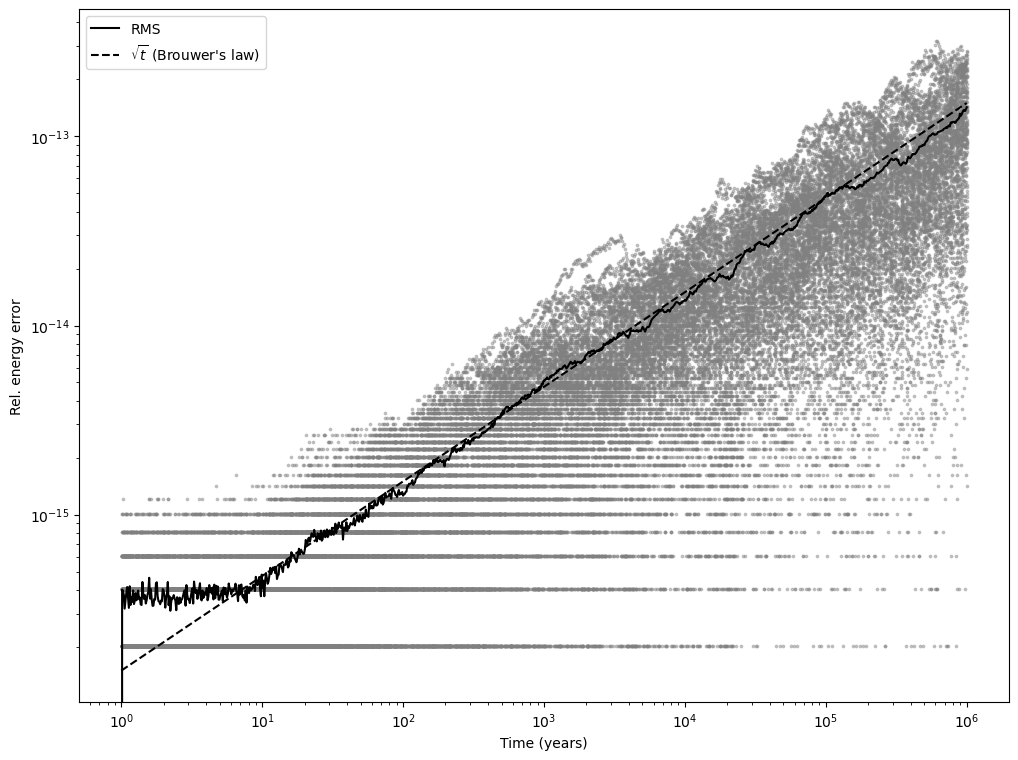

In [13]:
from matplotlib.pylab import plt
fig = plt.figure(figsize = (12, 9))

# Use log scale on both axes.
plt.xscale('log')
plt.yscale('log')

# Compute the initial energy.
E0 = en_cf(tres[0])[0]

# Compute the energy error.
E_err = np.array([abs((E0 - en_cf(_)[0]) / E0) for _ in tres])

# Plot it.
plt.plot(t_grid, E_err, color='gray', marker='.',
         linestyle='None', alpha=.4, markersize=3.5)

# Plot the root mean square computed over all
# data points at each timestep.
plt.plot(t_grid, np.sqrt(np.mean(E_err*E_err, axis = 1)), color='k', label="RMS")

# Plot sqrt(t).
plt.plot(t_grid, 1.5e-16 * np.sqrt(t_grid), 'k--', label="$\sqrt{t}$ (Brouwer's law)")

plt.xlabel("Time (years)")
plt.ylabel("Rel. energy error")
plt.legend();

The plot clearly shows how the average energy error starts out around machine precision and then begins to grow following Brouwer's law. These results indicate that heyoka.py is able to optimally conserve the invariants of a dynamical system over long-term integrations.